## Empirical Analysis

Statistical techniques used : Vector Autoregression, Impulse Response Functions and Forecast Error Vector Decompositon

Focus is on the measures of labor utilization and inflation which are:

1. U1 Rate - Persons Unemployed 15 weeks or longer, as a percent of the civilian labor force
2. U2 Rate - Unemployment Rate: Job Losers
3. U3 Unemployment rate (urate)
4. U4 Rate - Total Unemployed Plus Discouraged Workers, as a Percent of the Civilian Labor Force Plus Discouraged Workers
5. U5 Rate - Special Unemployment Rate: Unemployed and Marginally Attached Workers
6. U6 Rate - Total unemployed, plus all marginally attached workers plus total employed part time for economic 
7. Prime Age Employment to Population Ratio: 25-54 years (PEPOP)


In [27]:
# Import necessary modules
import numpy as np
import pandas as pd 
from matplotlib import pyplot
import matplotlib.pyplot as plt  # For plotting graphs 
%matplotlib inline

# standardizes the size of all plots, rather than typing plot(figsize = (12,6)) everytime
from pylab import rcParams
rcParams['figure.figsize'] = 12,6 

from scipy import stats
from datetime import datetime
from functools import reduce
import datetime
import quandl


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import scipy.stats as sp # SciPy for linear regression.

quandl.ApiConfig.api_key = '-kesKc4A8jkkBwyX3rSX'

In [6]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# imported the relavant macroecon variables

data = quandl.get(["FRED/ANFCI", # Chicago Fed National Financial Condition Index
                   "FRED/T10YFF", # 10 year Treasury - FFR
                   "FRED/T1YFFM", # 1 year Treasury - FFR
                   
                   "FRED/FEDFUNDS", # Federal Funds Rate
                   "UMICH/SOC1", # UMich: Consumer Sentiment Index
                   "FRED/RECPROUSM156N", # Smoothed U.S. Recession Probabilities
                   "FRED/GDPC1", # Real GDP
                   "FRED/INDPRO", # Industrial Production Index
                   "FRED/WALCL", # Total Assets (Less Eliminations From Consolidation)
                   "FRED/LNS12300060", # Employment to population ratio: 25-54 Yrs
                   
                   "FRED/RPONTSYD", # Overnight Repurchase Agreements: Treasury Securities Purchased by Fed in OMO
                   "FRED/AHETPI", # Average Hourly Earnings for Production & Nonsupervisory Employees
                   "FRED/CPIAUCSL", # CPI
                   "FRED/PSAVERT", # Personal Savings Rate
                   "FRED/CCSA", # UI claims 
                   "FRED/THREEFF4", # Fitted Instantaneous Forward Rate 4 Years Hence
                   "FRED/DGS1", # 1-Year Treasury Constant Maturity Rate
                   "FRED/T5YIE", # 5-Year Breakeven Inflation Rate
                   "FRED/T5YIFRM", # 5-Year, 5-Year Forward Inflation Expectation Rate
                   
                   "FRED/U1RATE",
                   "FRED/U2RATE", 
                   "FRED/UNRATE",
                   "FRED/U4RATE",
                   "FRED/U5RATE",
                   "FRED/U6RATE"],
                  start_date="1978-01-01", end_date="2020-04-01",collapse = 'monthly',date_parser=parser)
data.tail()

,FRED/ANFCI - Value,FRED/T10YFF - Value,FRED/T1YFFM - Value,FRED/FEDFUNDS - Value,UMICH/SOC1 - Index,FRED/RECPROUSM156N - Value,FRED/GDPC1 - Value,FRED/INDPRO - Value,FRED/WALCL - Value,FRED/LNS12300060 - Value,...,FRED/THREEFF4 - Value,FRED/DGS1 - Value,FRED/T5YIE - Value,FRED/T5YIFRM - Value,FRED/U1RATE - Value,FRED/U2RATE - Value,FRED/UNRATE - Value,FRED/U4RATE - Value,FRED/U5RATE - Value,FRED/U6RATE - Value
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,-0.66,0.37,0.00,1.55,99.3,12.55,NaN,109.6357,4165591.0,80.4,...,1.6523,1.59,1.68,1.81,1.2,1.6,3.5,3.7,4.2,6.7
2020-01-31,-0.70,-0.08,-0.02,1.55,99.8,25.98,18974.702,109.1337,4151630.0,80.6,...,1.1946,1.45,1.60,1.79,1.2,1.6,3.6,3.8,4.4,6.9
2020-02-29,-0.50,-0.45,-0.17,1.58,101.0,57.32,NaN,109.2569,4158637.0,80.5,...,0.7941,0.97,1.33,1.65,1.2,1.7,3.5,3.8,4.4,7.0
2020-03-31,0.43,0.62,-0.30,0.65,89.1,100.00,NaN,104.3262,5254278.0,79.6,...,0.4898,0.17,0.49,1.30,1.2,2.4,4.4,4.7,5.2,8.7
2020-04-30,NaN,0.56,0.13,0.05,NaN,100.00,NaN,92.5919,5811607.0,69.7,...,0.4332,0.16,0.56,1.45,1.1,13.2,14.7,15.1,16.0,22.8


In [13]:
data.columns = ['FRED/ANFCI - Value', 'FRED/T10YFF - Value', 'FRED/T1YFFM - Value', 'FRED/FEDFUNDS - Value', 
                'UMICH/SOC1 - Index', 'FRED/RECPROUSM156N - Value', 'FRED/GDPC1 - Value', 'FRED/INDPRO - Value',
                'FRED/WALCL- Value', 'FRED/LNS12300060 - Value', 'FRED/RPONTSYD - Value', 'FRED/AHETPI - Value',
                'FRED/CPIAUCSL - Value', 'FRED/PSAVERT - Value', 'FRED/CCSA - Value', 'FRED/THREEFF4 - Value',
                'FRED/DGS1 - Value','FRED/T5YIE - Value', 'FRED/T5YIFRM - Value', 'FRED/U1RATE - Value', 
                'FRED/U2RATE - Value','FRED/UNRATE - Value','FRED/U4RATE - Value','FRED/U5RATE - Value',
                'FRED/U6RATE - Value']

# rename the columns
data.rename(columns={'FRED/ANFCI - Value': 'FCI',
                     'FRED/T10YFF - Value': '10yrtre-ffr',
                     'FRED/T1YFFM - Value': '1yrtre-ffr',
                     'FRED/FEDFUNDS - Value': 'fed_fundsR',
                     'UMICH/SOC1 - Index': 'CSI',
                     'FRED/RECPROUSM156N - Value': 'rec_prob',
                     'FRED/GDPC1 - Value': 'real_GDP',
                     'FRED/INDPRO - Value': 'IPI',
                     'FRED/WALCL- Value': "total_assets",
                     'FRED/LNS12300060 - Value': 'pepop',
                     'FRED/RPONTSYD - Value': 'repo_purchFed',
                     'FRED/AHETPI - Value': 'hour_earn', 
                     'FRED/CPIAUCSL - Value': 'CPI',
                     'FRED/PSAVERT - Value': 'PSR',
                     'FRED/CCSA - Value': 'UI_claims',
                     'FRED/THREEFF4 - Value':'4forwardR',
                     'FRED/DGS1 - Value': '1yr_trR',
                    'FRED/T5YIE - Value': '5break_infR',
                    'FRED/T5YIFRM - Value': '5yr-5forward_infexpR',
                     
                    'FRED/U1RATE - Value': 'u1rate',
                    'FRED/U2RATE - Value': 'u2rate',
                    'FRED/U4RATE - Value': 'u4rate',
                    'FRED/U5RATE - Value': 'u5rate',
                    'FRED/U6RATE - Value': 'u6rate',
                    'FRED/UNRATE - Value': 'unrate'}, inplace=True)
data.head()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,real_GDP,IPI,total_assets,pepop,...,4forwardR,1yr_trR,5break_infR,5yr-5forward_infexpR,u1rate,u2rate,unrate,u4rate,u5rate,u6rate
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-31,-0.76,1.15,0.58,6.70,83.7,10.45,6329.791,49.2066,NaN,73.0,...,NaN,7.26,NaN,NaN,1.6,2.8,6.4,NaN,NaN,NaN
1978-02-28,-0.69,1.21,0.56,6.78,84.3,0.15,NaN,49.4502,NaN,73.2,...,NaN,7.32,NaN,NaN,1.6,2.7,6.3,NaN,NaN,NaN
1978-03-31,-0.24,1.18,0.52,6.79,78.8,0.00,NaN,50.3928,NaN,73.3,...,NaN,7.48,NaN,NaN,1.5,2.6,6.3,NaN,NaN,NaN
1978-04-30,0.15,0.99,0.56,6.89,81.6,0.00,6574.390,51.4368,NaN,73.5,...,NaN,7.70,NaN,NaN,1.5,2.6,6.1,NaN,NaN,NaN
1978-05-31,0.23,0.99,0.46,7.36,82.9,0.15,NaN,51.6276,NaN,73.4,...,NaN,7.94,NaN,NaN,1.4,2.5,6.0,NaN,NaN,NaN


In [14]:
# since the Real GDP is quarterly, I have used a spline interpolation method to convert into monthly data
inter_realGDP = data['real_GDP'].interpolate(method='spline', order =3)
inter_realGDP.tail(10)

Date
2019-07-31    19121.112000
2019-08-31    19167.056109
2019-09-30    19205.200335
2019-10-31    19221.970000
2019-11-30    19200.670650
2019-12-31    19123.813367
2020-01-31    18974.702000
2020-02-29    18755.093966
2020-03-31    18418.913945
2020-04-30    17978.472195
Name: real_GDP, dtype: float64

In [15]:
merged = pd.merge(data, inter_realGDP, on = 'Date') # merged the interpolated GDP data with the rest of the dataset

merged1 = merged.drop('real_GDP_x', axis =1).rename(columns={'real_GDP_y': 'inter_realGDP'}) 
merged1.drop(merged1.tail(1).index,inplace= True)# drop the last row with missing values as it contains NaN

merged1['real_wage'] = merged1['hour_earn']/merged1['CPI'] # Add a column that calculates the real wage
#merged1.head()

In [16]:
# Calculates the percent change of all the variables
change = merged1.pct_change()
#change.head()

In [17]:
# drops rows with NaN values, and replaces inf values with 0
short = change.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
short.head()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,IPI,total_assets,pepop,repo_purchFed,...,5break_infR,5yr-5forward_infexpR,u1rate,u2rate,unrate,u4rate,u5rate,u6rate,inter_realGDP,real_wage
Date,,,,,,,,,,,,,,,,,,,,,
2003-02-28,0.102564,-0.108614,-0.666667,0.016129,-0.030340,9.000000,0.001422,0.012866,0.000000,0.423729,...,0.174497,0.018868,0.000000,0.031250,0.017241,0.016393,0.014706,0.020202,0.002056,-0.000872
2003-03-31,0.139535,0.029412,-1.250000,-0.007937,-0.028786,0.200000,-0.002314,0.004209,0.001267,-0.828571,...,-0.057143,-0.050926,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009901,0.002794,-0.002937
2003-04-30,0.285714,0.053061,-2.000000,0.008000,0.108247,-0.166667,-0.007149,0.029344,0.001266,7.819444,...,-0.121212,-0.029268,0.045455,0.000000,0.016949,0.016129,0.014493,0.020000,0.003729,0.004478
2003-05-31,0.095238,-0.189922,-9.000000,0.000000,0.070930,-0.900000,0.000280,-0.001873,-0.002528,-1.000000,...,-0.131034,-0.005025,0.000000,0.060606,0.016667,0.015873,0.014286,-0.009804,0.005285,0.004918
2003-07-31,0.000000,0.650718,-1.523810,-0.172131,0.013378,0.600000,0.004403,-0.005004,-0.001267,0.000000,...,0.206897,0.166667,0.041667,0.000000,-0.015873,-0.030303,-0.013889,0.000000,0.005808,-0.000671


In [12]:
short.info() # after dropping the missing values, the dataset truncates to 150 rows

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2003-02-28 to 2020-03-31
Data columns (total 26 columns):
FCI                     150 non-null float64
10yrtre-ffr             150 non-null float64
1yrtre-ffr              150 non-null float64
fed_fundsR              150 non-null float64
CSI                     150 non-null float64
rec_prob                150 non-null float64
IPI                     150 non-null float64
total_assets            150 non-null float64
pa_emp-pop_ratio        150 non-null float64
repo_purchFed           150 non-null float64
hour_earn               150 non-null float64
CPI                     150 non-null float64
PSR                     150 non-null float64
UI_claims               150 non-null float64
4forwardR               150 non-null float64
1yr_trR                 150 non-null float64
5break_infR             150 non-null float64
5yr-5forward_infexpR    150 non-null float64
u1rate                  150 non-null float64
u2rate               

Graph of measure of inflation (real wage growth) vs measure of employment (prime age employment to population ratio)

While it apprears that they may be weekly positively correlated as they almost move in tandem with each other in several time periods; however, they are weekly negative correlated and stationary.

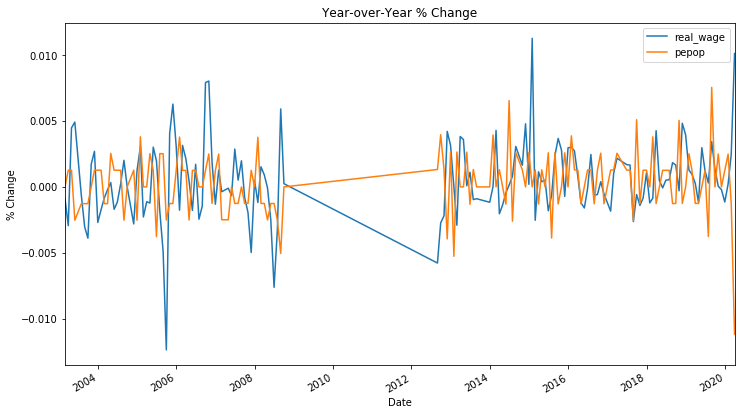

In [19]:
ax = short[['real_wage', 'pepop']].plot(figsize=(12,7),
                                            xlim=['2003-02-28','2020-03-31'], title='Year-over-Year % Change')
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='% Change');

In [20]:
short[['real_wage', 'pepop']].corr() # slightly negatively correlated and stationary variables

,real_wage,pepop
real_wage,1.000000,-0.130632
pepop,-0.130632,1.000000


In [23]:
data_list = short[['10yrtre-ffr', '1yrtre-ffr', 'fed_fundsR', 'CSI', 'rec_prob', 'IPI','pepop', 'PSR',
               'UI_claims', 'inter_realGDP', 'real_wage', 'total_assets', 'repo_purchFed','4forwardR', '1yr_trR',
                  '5break_infR', '5yr-5forward_infexpR', 'unrate', 'u1rate', 'u2rate', 'u4rate', 'u5rate', 'u6rate']]

## Augmented Dickey Fuller Test to check for Stationarity

The series with unit root are: percent changes in the following variables:
UI Claims, 1 year maturity Treasury rate, and real GDP

In [24]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for stationarity of a given series and print report"""
    
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    # print sumamry
    print(f'     Augmented Dickey-Fuller Test on "{name}"', "\n    ", '-'*47)
    print(f'  Null Hypothesis: Data has unit too. Non-Stationary.')
    print(f'  Significance Level    = {signif}')
    print(f'  Test Statistic        = {output["test_statistic"]}')
    print(f'  No. of Lags Chosen    = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f'  Critical Value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting null hypothesis.")
          print(f" => Series is stationary.")
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is non-stationary.")
          
     # ADF Test on each column
for name, column in data_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "10yrtre-ffr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -13.8862
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.475
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "1yrtre-ffr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -11.1003
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.475
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "fed_fundsR" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Sta

In [25]:
# stationarizes the 4 variables by differencing, and concats them with the dataset
short1 = short[['UI_claims','1yr_trR','inter_realGDP', 'u4rate']].diff().add_suffix("_diff")
stat = pd.concat([short, short1], axis=1)

# drops rows with NaN values, and replaces inf values with 0
stat1 = stat.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
stat1.tail()

In [35]:
stat1.tail()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,IPI,total_assets,pepop,repo_purchFed,...,unrate,u4rate,u5rate,u6rate,inter_realGDP,real_wage,UI_claims_diff,1yr_trR_diff,inter_realGDP_diff,u4rate_diff
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-30,-0.028571,1.000000,-1.090909,-0.153005,0.013613,0.153846,0.009280,0.008222,0.000000,0.113362,...,-0.027778,-0.026316,0.000000,-0.014493,-0.001108,-0.000208,0.004717,0.171466,-0.001981,-0.053343
2019-12-31,-0.029412,0.681818,-1.000000,0.000000,0.025826,12.944444,-0.003663,0.027811,0.001245,-0.752234,...,0.000000,0.000000,-0.023256,-0.014706,-0.004003,-0.001142,0.041168,-0.052002,-0.002895,0.026316
2020-01-31,0.060606,-1.216216,0.000000,0.000000,0.005035,1.070120,-0.004579,-0.003352,0.002488,0.849311,...,0.028571,0.027027,0.047619,0.029851,-0.007797,0.000223,-0.056512,-0.081800,-0.003794,0.027027
2020-02-29,-0.285714,4.625000,7.500000,0.019355,0.012024,1.206313,0.001129,0.001688,-0.001241,-0.709595,...,-0.027778,0.000000,0.000000,0.014493,-0.011574,0.002459,-0.018410,-0.242984,-0.003777,-0.027027
2020-03-31,-1.860000,-2.377778,0.764706,-0.588608,-0.117822,0.744592,-0.045129,0.263462,-0.011180,-0.960317,...,0.257143,0.236842,0.181818,0.242857,-0.017925,0.010121,3.413382,-0.493708,-0.006351,0.236842


In [30]:
stat_list = stat1[['UI_claims_diff','1yr_trR_diff','inter_realGDP_diff', 'u4rate_diff']]

# ADF Test on each column
for name, column in stat_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "UI_claims_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -3.8565
  No. of Lags Chosen    = 1
  Critical Value 1%     = -3.476
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0024. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "1yr_trR_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -4.4594
  No. of Lags Chosen    = 12
  Critical Value 1%     = -3.479
  Critical Value 5%     = -2.883
  Critical Value 10%    = -2.578
 => P-Value = 0.0002. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "inter_realGDP_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has

After differencing, the differeced values of percent change in UI claims, constant 1 year Treasury maturity securities, and real GDP are stationary.

## Autocorrelation Plots

These are the ACFs of two of the three variables with unit root

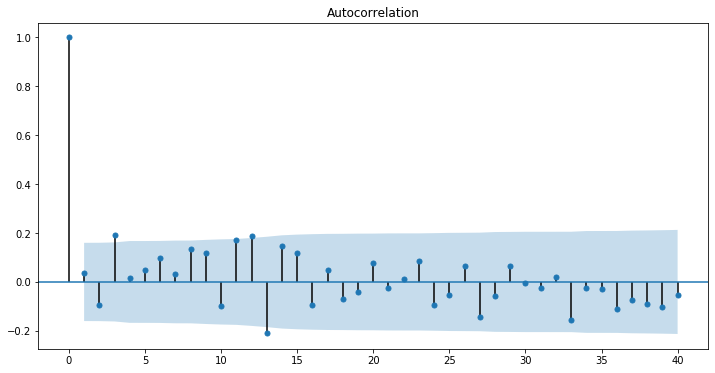

In [28]:
# makes the ACF plot
plot_acf(short['1yr_trR'], lags = 40)
# the plots show strong autocorrelation of lags as spikes gradually reduce, instead of plumeting to 0.
pyplot.show()

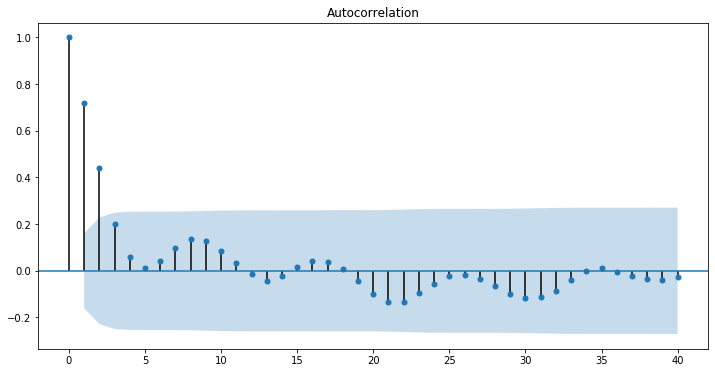

In [29]:
plot_acf(short['inter_realGDP'], lags = 40)
pyplot.show()

## Vector Autoregression Model (VAR)

As a reduced form model, VAR's coefficients are hard to interpret. Instead, we canconstruct the impulse-response functions (IRF) and forecast error variance decomposition (FEVD) to gauge how the variables affect each other.

In [50]:
model1 = VAR(stat1[['pepop','unrate','u1rate', 'u2rate', 'u4rate_diff', 'u5rate', 'u6rate', 'fed_fundsR']])
results1 = model1.fit(2)
results1.summary()

/Users/sudikshajoshi/anaconda3/envs/TSA_COURSE/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jun, 2020
Time:                     08:46:58
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -59.8855
Nobs:                     147.000    HQIC:                  -61.5280
Log likelihood:           3072.26    FPE:                6.22486e-28
AIC:                     -62.6521    Det(Omega_mle):     2.59369e-28
--------------------------------------------------------------------
Results for equation pepop
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000211         0.000199            1.061           0.288
L1.pepop              -0.335369         0.097043           -3.456           0.001
L1.unrate              0.035391         0.016300        

## Impulse Response Functions

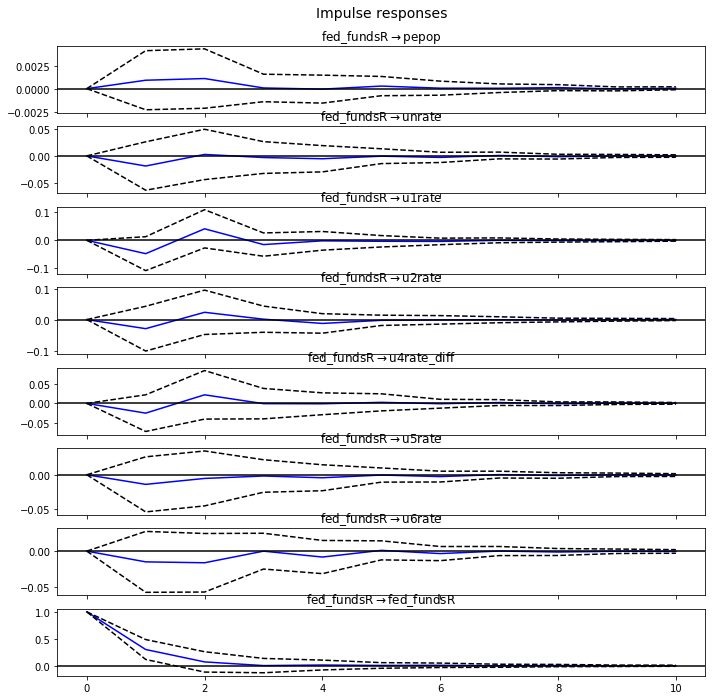

In [51]:
irf1 = results1.irf(10)
irf1.plot(impulse='fed_fundsR');

When there is a positive shock of federal funds rate on the changes in pepop, the percent change in ISI boosts by around 0.001 units and flattens at that level for 2 periods. After that, it gradually descends linearly until the affect of the shock attentuates and dissipates after the 3rd period.

On the contrary, all other labor utilization shocks face a negative impact from change in federal funds rate. From the IRFs, u5rate appears to have minimal shock impact, than u1rate has as it plunges to the negative territory by 0.05 in period 1, then rises by 0.1 units to the 0.05 level in period 2. Thereafter, it converges to the steady state level.

## Forecast Error Vector Decomposition (FEVD)

In [52]:
fevd = results1.fevd(5) # forecast period is 5 year=> forecasting upto 5 years into the future
fevd.summary()

FEVD for pepop
        pepop    unrate    u1rate    u2rate  u4rate_diff    u5rate    u6rate  fed_fundsR
0    1.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000    0.000000
1    0.939035  0.009213  0.011019  0.009529     0.012345  0.015299  0.001430    0.002131
2    0.882839  0.052350  0.017390  0.011100     0.012538  0.017268  0.001692    0.004823
3    0.859375  0.051333  0.025919  0.012434     0.016254  0.021200  0.008864    0.004621
4    0.839310  0.054455  0.025320  0.017480     0.015897  0.033895  0.009125    0.004519

FEVD for unrate
        pepop    unrate    u1rate    u2rate  u4rate_diff    u5rate    u6rate  fed_fundsR
0    0.179961  0.820039  0.000000  0.000000     0.000000  0.000000  0.000000    0.000000
1    0.170486  0.684991  0.005630  0.028667     0.037368  0.009462  0.059105    0.004291
2    0.154295  0.660068  0.011003  0.029056     0.033943  0.053302  0.054370    0.003964
3    0.161115  0.630553  0.017873  0.032572     0.032901  0.067170  0.053933  

Whilst impulse response functions delineate the impact of a shock to one endogenous variable on to the other variables in the VAR, a FEVD distinguishes the variation present in an endogenous variable into the component shocks to the VAR.

Variance decomposition shows how much a shock to one variable (e.g: pct change in U2 rate, unemployment rate, etc) impacts the variance of the forecast error of a different one (e.g: prime age population to employment ratio, U5 rate). So, in the short run, i.e. in the same period, the U6 rate itself explains 27.29% of the variance in its forecast error. The percent change in the following variables - u2rate, u5rate and fed_fundsR are strongly exogenous as they only weakly influence in predicting the u6rate in the present. But precent change in unrate explains 45.64 percent of variance in the error of u6rate (percent change), indicating that it is strongly endogenous as it has a strong influence on u6rate. 

However, in the long run, the influence of percent change in u6rate in explaining the variance in its forecast error has diminished from 27.29 to 21.95 percent, whereas other variables such as percent change in u1rate, u2rate, u5rate and fed_fundsR have an incremental influence, than they had in the short in the earlier periods in the short run. 

In [58]:
import statsmodels.api as sm # import statsmodels 
X = stat1['fed_fundsR']
y = stat1['u6rate']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 u6rate   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     20.92
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.01e-05
Time:                        09:58:17   Log-Likelihood:                 322.16
No. Observations:                 149   AIC:                            -640.3
Df Residuals:                     147   BIC:                            -634.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.283      0.778      -0.005       0.004
fed_fundsR    -0.0804      0.018     -4.574      0.000      -0.115      -0.046
==============================================================================
Omnibus:                      103.999   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1665.459
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      18.810   Cond. No.                         7.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model = VAR(short[['IPI','pepop', 'PSR', 'real_wage', 'total_assets', 'repo_purchFed']])
results = model.fit(2)
results.summary()

/Users/sudikshajoshi/anaconda3/envs/TSA_COURSE/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jun, 2020
Time:                     07:00:43
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -32.4579
Nobs:                     148.000    HQIC:                  -33.3957
Log likelihood:           1336.76    FPE:                1.65532e-15
AIC:                     -34.0375    Det(Omega_mle):     9.98843e-16
--------------------------------------------------------------------
Results for equation IPI
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.000447         0.000687           -0.651           0.515
L1.IPI                   0.175700         0.112775            1.558           0.119
L1.pepop                 0.578985         0.297252

## Impulse Response Functions (IRF)

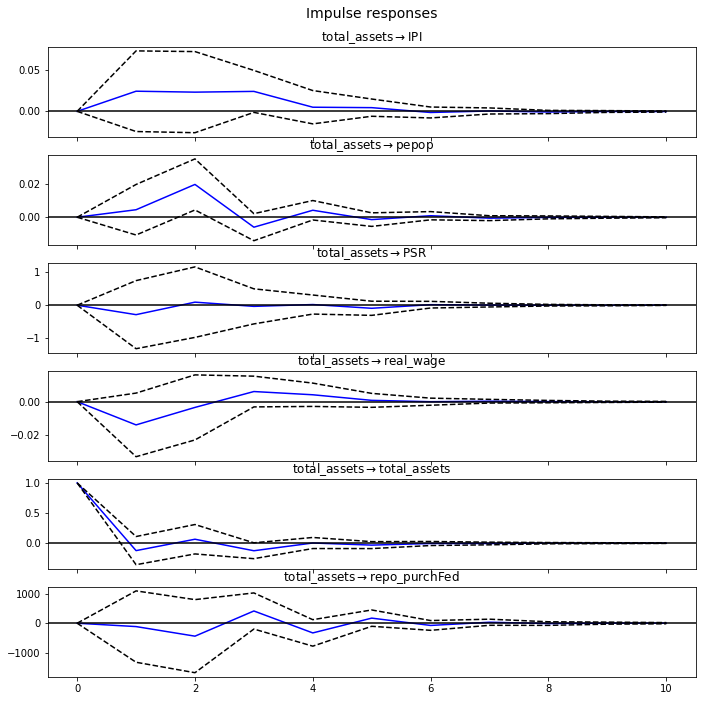

In [32]:
irf = results.irf(10)
irf.plot(impulse='total_assets');

When there is a positive shock of the total assets on the changes in industrial production index (IPI) i.e. when the Fed buys more total assets than normally would, the percent change in ISI boosts by slightly less than 0.025 units and flattens at that level from 1 to 2.5 periods. After that, it gradually descends linearly until the affect of the sock attentuates and dissipates after the 6th period. 

Similary, on applying a positive shock, the percent change in pepop ratio rises and reaches the peak in period 2, after which is tumbles down to the negative territory. Thereafter, the ratio approaches the steady state level.

The percent change in wage or wage growth initially react negatively, wherein it reaches the nadir at about -0.018 in period 1.5, and then pushes back up the orginal level of wage growth. There is a modicum of increase - slightly above 0 unit, after which it reduces to its steady state level.

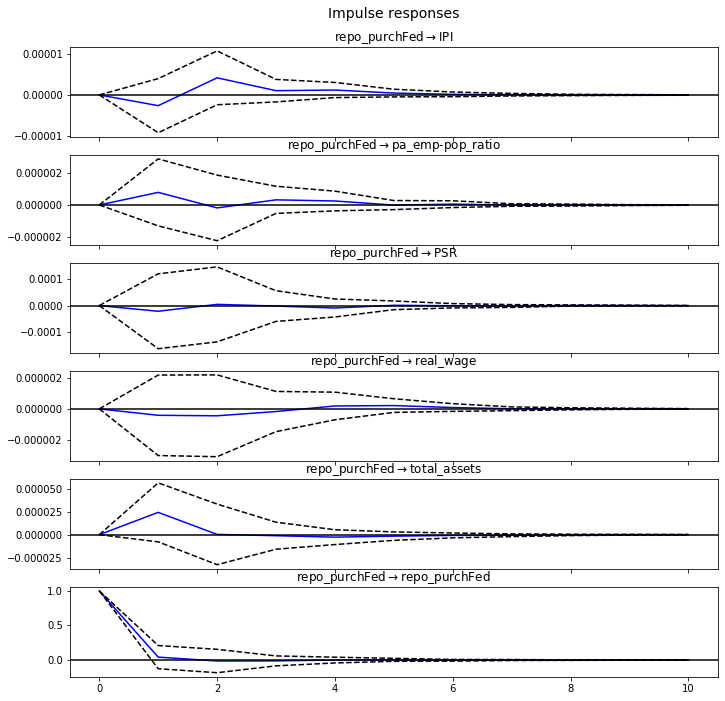

In [174]:
irf.plot(impulse='repo_purchFed');

As the Fed accerleates the monetary shock by buying more overnight repurchase agreements from the open market operations, there are hardly any conspicuous changes in the growth of personal savings rate. It mildly diminishes, and then reverts back to 0 after period 2, converging to the steady state level 5th period onwards. 

## Forecast Error Variance Decomposition (FEVD)

In [33]:
fevd = results.fevd(5)
fevd.summary()

FEVD for IPI
          IPI     pepop       PSR  real_wage  total_assets  repo_purchFed
0    1.000000  0.000000  0.000000   0.000000      0.000000       0.000000
1    0.952830  0.022506  0.003261   0.011376      0.006059       0.003968
2    0.923619  0.021586  0.013044   0.015473      0.012651       0.013627
3    0.916932  0.021452  0.012960   0.015493      0.019058       0.014104
4    0.915344  0.021958  0.012949   0.015471      0.019357       0.014921

FEVD for pepop
          IPI     pepop       PSR  real_wage  total_assets  repo_purchFed
0    0.091826  0.908174  0.000000   0.000000      0.000000       0.000000
1    0.094655  0.894323  0.000220   0.004475      0.002763       0.003564
2    0.092963  0.847221  0.000314   0.010808      0.045132       0.003561
3    0.092539  0.842318  0.001593   0.010842      0.048572       0.004137
4    0.092034  0.836175  0.001910   0.015224      0.050239       0.004419

FEVD for PSR
          IPI     pepop       PSR  real_wage  total_assets  repo_purc

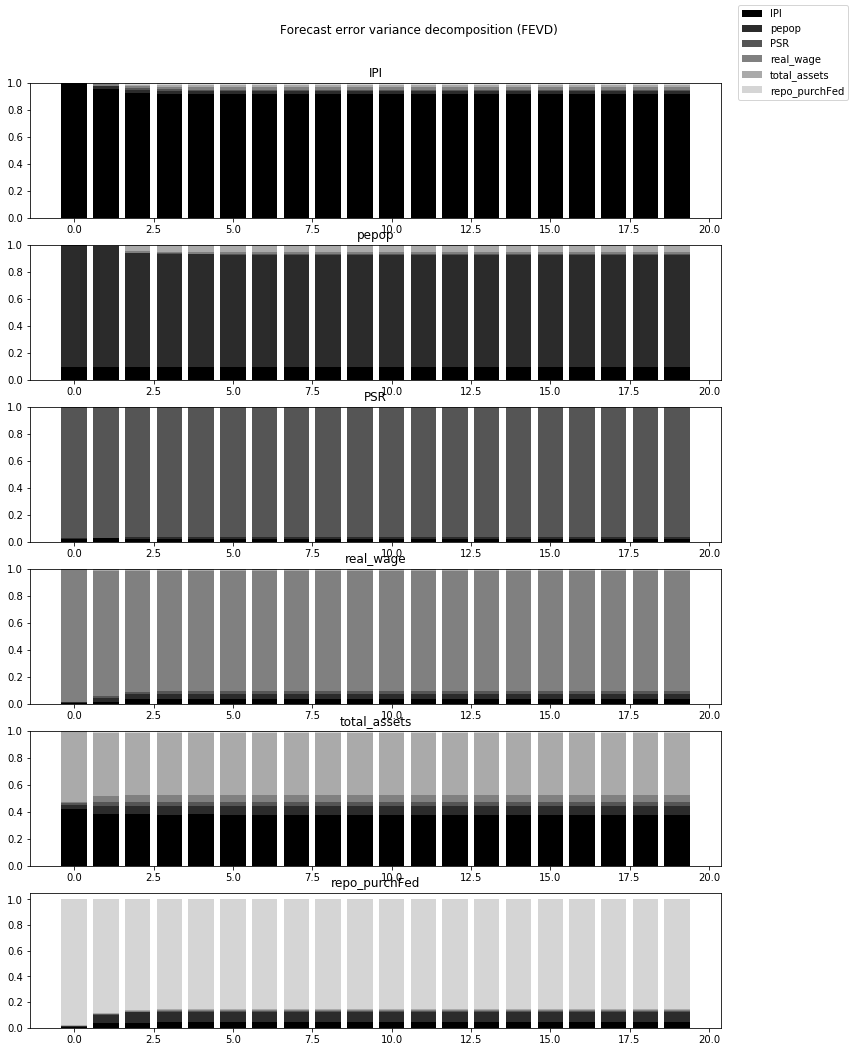

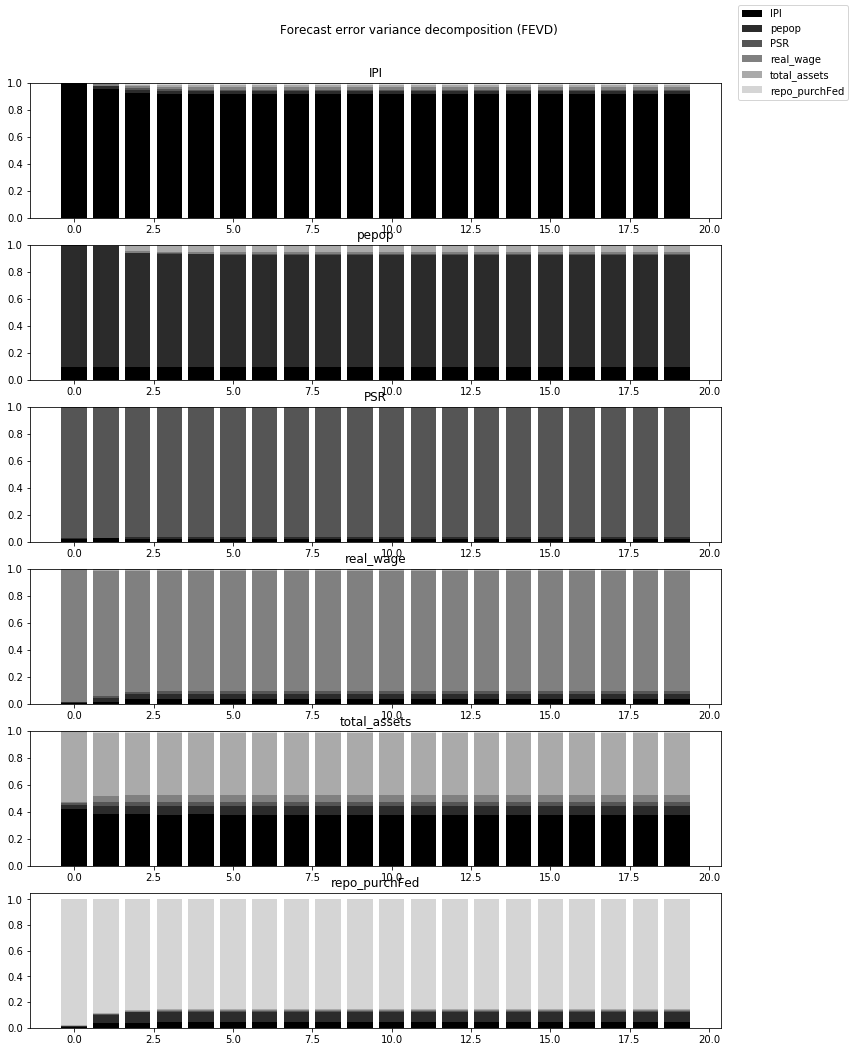

In [34]:
results.fevd(20).plot(figsize = (12,15))

Whilst impulse response functions delineate the impact of a shock to one endogenous variable on to the other variables in the VAR, a VECM distinguishes the variation present in an endogenous variable into the component shocks to the VAR.

Variance decomposition shows how much a shock to one variable (e.g: pct change in wage growth, personal savings rate) impacts the variance of the forecast error of a different one (e.g: pct change in prime age population to employment ratio, ISI). So, in the short run, i.e. in the same period, we can explain 98.84% of the variance in the forecast error of real wage growth by real wage growth itself. It is strongly exogenous as the percent change in pther variables - PSR, total assets, real wage, etc, only weakly influence in predicting the ISI in the future. 

However, in the long run, the influence of  percent change in ISI in explaining the variance in its forecast error has diminished from 98.84 to 88.71 percent. 